# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. 

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [29]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "testing"   # Used for tflite Filename
Training_Percentage = 0.3              # 0.0 = Use all Images for Training
Epochs = 200

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path
from tensorflow.keras import regularizers


loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 15x25 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [32]:
ls ../data/raw_images

converter.py  labelled_bmp_data_equal_combined_final/
data1/        labelled_bmp_data_equal_combined_final.zip
data2/        labelled_bmp_data_equal_combined_orig/
data3/        labelled_bmp_data.zip
data4/        labelled_grayscale_png.zip
data5/        sample/
fine/         sample_jpg/
fine.zip


In [33]:
Input_dir='../data/raw_images/fine'

files = glob.glob(Input_dir + '/*.bmp')
x_data = []
y_data = []

for file in files:
    base = os.path.basename(file)
    target = base[0:1]
    category = int(target)
    test_image = Image.open(file)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)/255.0
y_data = np.array(y_data)
y_data = to_categorical(y_data, 10)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(9278, 25, 15, 3)
(9278, 10)


In [34]:
len(x_data)

9278

In [35]:
len(X_train)

6494

In [36]:
x_data[2]

array([[[0.7216, 0.8471, 0.8157],
        [0.7529, 0.8627, 0.8157],
        [0.7529, 0.8627, 0.8157],
        ...,
        [0.7216, 0.8   , 0.7529],
        [0.6902, 0.7686, 0.7216],
        [0.6588, 0.7373, 0.6902]],

       [[0.7529, 0.8627, 0.8157],
        [0.7529, 0.8627, 0.8157],
        [0.7529, 0.8627, 0.8157],
        ...,
        [0.7216, 0.8   , 0.7529],
        [0.6902, 0.7686, 0.7216],
        [0.6588, 0.7373, 0.6588]],

       [[0.7529, 0.8627, 0.8157],
        [0.7529, 0.8784, 0.8157],
        [0.7529, 0.8784, 0.8157],
        ...,
        [0.7216, 0.8   , 0.7529],
        [0.6902, 0.7686, 0.7216],
        [0.6588, 0.7216, 0.6588]],

       ...,

       [[0.6588, 0.7373, 0.6588],
        [0.6275, 0.7216, 0.6588],
        [0.5961, 0.7216, 0.6588],
        ...,
        [0.5961, 0.7059, 0.6275],
        [0.5961, 0.6902, 0.6275],
        [0.5647, 0.6745, 0.5961]],

       [[0.6275, 0.7059, 0.6588],
        [0.5961, 0.6902, 0.6275],
        [0.5647, 0.6745, 0.6275],
        .

### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (15, 25, 3)
* Number of output layers: 10
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [37]:
model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(25,15,3)),
        tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activity_regularizer=regularizers.L2(1e-5),  activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
        tf.keras.layers.Conv2D(32, kernel_size=3, padding='same',activity_regularizer=regularizers.L2(1e-5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
        tf.keras.layers.Conv2D(16, kernel_size=3, padding='same',activity_regularizer=regularizers.L2(1e-5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])


In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 25, 15, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 8, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 8, 32)         18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 4, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 4, 16)          4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 2, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)              

In [39]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), metrics = ["accuracy"])

/home/george/anaconda3/envs/gputensorflow/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [40]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.1
Rotation_Angle = 0
ZoomRange = 0.0
# Epochs = 10
callback = []

early_stopping = EarlyStopping(
                    monitor="val_accuracy",
                    min_delta=0,
                    patience=12,
                    verbose=0,
                    mode="auto",
                    baseline=None,
                    restore_best_weights=False,
                )

# datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
#                              height_shift_range=[-Shift_Range,Shift_Range],
#                              brightness_range=[1-Brightness_Range,1+Brightness_Range],
#                              zoom_range=[1-ZoomRange, 1+ZoomRange],
#                              rotation_range=Rotation_Angle,vertical_flip=True)

datagen = ImageDataGenerator(featurewise_center=False,
                                 featurewise_std_normalization=False,
                                 rotation_range=.3,
                                 width_shift_range=0.4,
                                 height_shift_range=0.0,)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size, shuffle = True,save_format ="bmp" )
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size, shuffle = False, save_format ="bmp")
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epochs, callbacks=[early_stopping])
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size, shuffle = True,)
    history = model.fit(train_iterator, epochs = Epochs)



Epoch 1/200
2320/2320 [==============================] - 9s 4ms/step - loss: 2.2898 - accuracy: 0.1453 - val_loss: 2.2694 - val_accuracy: 0.1692
Epoch 2/200
2320/2320 [==============================] - 8s 4ms/step - loss: 2.2248 - accuracy: 0.1732 - val_loss: 2.1436 - val_accuracy: 0.2015
Epoch 3/200
2320/2320 [==============================] - 8s 4ms/step - loss: 2.1250 - accuracy: 0.2065 - val_loss: 2.0381 - val_accuracy: 0.2425
Epoch 4/200
2320/2320 [==============================] - 9s 4ms/step - loss: 2.0519 - accuracy: 0.2469 - val_loss: 1.9530 - val_accuracy: 0.3585
Epoch 5/200
2320/2320 [==============================] - 9s 4ms/step - loss: 1.9476 - accuracy: 0.3030 - val_loss: 1.8136 - val_accuracy: 0.3991
Epoch 6/200
2320/2320 [==============================] - 8s 4ms/step - loss: 1.7702 - accuracy: 0.3949 - val_loss: 1.6486 - val_accuracy: 0.5219
Epoch 7/200
2320/2320 [==============================] - 8s 4ms/step - loss: 1.5003 - accuracy: 0.5087 - val_loss: 1.2695 - val_ac

2320/2320 [==============================] - 8s 4ms/step - loss: 0.0584 - accuracy: 0.9814 - val_loss: 0.0477 - val_accuracy: 0.9849
Epoch 58/200
2320/2320 [==============================] - 8s 4ms/step - loss: 0.0630 - accuracy: 0.9803 - val_loss: 0.0399 - val_accuracy: 0.9864
Epoch 59/200
2320/2320 [==============================] - 8s 4ms/step - loss: 0.0632 - accuracy: 0.9793 - val_loss: 0.0483 - val_accuracy: 0.9813
Epoch 60/200
2320/2320 [==============================] - 8s 4ms/step - loss: 0.0626 - accuracy: 0.9810 - val_loss: 0.0404 - val_accuracy: 0.9871
Epoch 61/200
2320/2320 [==============================] - 8s 4ms/step - loss: 0.0623 - accuracy: 0.9807 - val_loss: 0.0355 - val_accuracy: 0.9871
Epoch 62/200
2320/2320 [==============================] - 8s 4ms/step - loss: 0.0594 - accuracy: 0.9815 - val_loss: 0.0382 - val_accuracy: 0.9856
Epoch 63/200
2320/2320 [==============================] - 8s 4ms/step - loss: 0.0652 - accuracy: 0.9782 - val_loss: 0.0546 - val_accuracy

In [42]:
final_loss, final_acc = model.evaluate(X_test, y_test)

87/87 [==============================] - 0s 3ms/step - loss: 0.0050 - accuracy: 1.0000


In [43]:
model.save("final_v2.h5")

In [44]:
ls

converted_model.tflite
digit_model.h5
digit_model_quant.tflite
digit_model_quant.tflite_int8_34.tflite
digit_model_quant.tflite_int8_42.tflite
digit_model_quant.tflite_int8.tflite
digit_model_quant.tflite_int8_v2.tflite
digit_model_quant.tflite_uint8_v2.tflite
digit_model_quant_v2.tflite
draw_digit_with_perpective_transform_crop_save_image_colored1.ipynb
draw_digit_with_perpective_transform_crop_save_image_colored2.ipynb
draw_digit_with_perpective_transform_crop_save_image_colored3.ipynb
draw_digit_with_perpective_transform_crop_save_image_colored4.ipynb
draw_digit_with_perpective_transform_crop_save_image_colored5.ipynb
final.h5
final_v2.h5
image_augumentation.ipynb
inference.ipynb
inference_jpg.ipynb
output/
training_notebook2.ipynb
training_notebook3.ipynb
training_notebook4.ipynb
train_notebook_final.ipynb
walkthrough.ipynb


### Learing result
 
* Visualization of the training and validation results

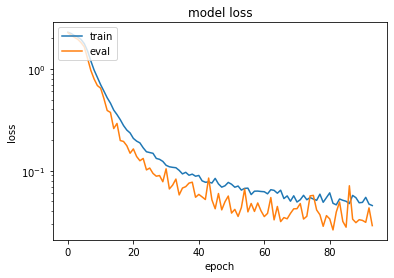

In [45]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

In [46]:
Input_dir='../data/raw_images/sample_jpg'
files = glob.glob(Input_dir + '/*.jpg')

In [49]:
for file in files[:100]: 
    base = os.path.basename(file)
    target = base[0:1]
    image_bmp = Image.open(file)
    test_image = np.array(image_bmp, dtype="float32")
    img = np.reshape(test_image,[1,25,15,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    print(file[:31], classes)
    

../data/raw_images/sample_jpg/3 3
../data/raw_images/sample_jpg/7 5
../data/raw_images/sample_jpg/1 2
../data/raw_images/sample_jpg/5 5
../data/raw_images/sample_jpg/1 1
../data/raw_images/sample_jpg/4 4
../data/raw_images/sample_jpg/0 6
../data/raw_images/sample_jpg/2 2
../data/raw_images/sample_jpg/8 6
../data/raw_images/sample_jpg/7 7
../data/raw_images/sample_jpg/4 3
../data/raw_images/sample_jpg/7 5
../data/raw_images/sample_jpg/5 5
../data/raw_images/sample_jpg/9 5
../data/raw_images/sample_jpg/0 0
../data/raw_images/sample_jpg/8 6
../data/raw_images/sample_jpg/6 5
../data/raw_images/sample_jpg/4 3
../data/raw_images/sample_jpg/9 5
../data/raw_images/sample_jpg/7 5
../data/raw_images/sample_jpg/8 6
../data/raw_images/sample_jpg/2 2
../data/raw_images/sample_jpg/3 3
../data/raw_images/sample_jpg/4 3
../data/raw_images/sample_jpg/5 5
../data/raw_images/sample_jpg/6 6
../data/raw_images/sample_jpg/8 6
../data/raw_images/sample_jpg/8 6
../data/raw_images/sample_jpg/6 6
../data/raw_im

### Save the model

* Save the model to the file with the "h5" file format

## Post training weight quantization

* Depending on your requirements (performance, memory and runtime), post training quantization can be done in two ways.

Approach #1:  Post training weight quantization (quantizes weights only) In this case only weights are quantized to int8 but activations remain as they were. Inference input and output are floating-point.

In [50]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
# Post training quantization
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open("digit_model_quant_v2.tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmp6smyl2jg/assets


INFO:tensorflow:Assets written to: /tmp/tmp6smyl2jg/assets
2022-10-17 00:44:58.165339: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-10-17 00:44:58.165515: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-17 00:44:58.167595: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.011ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.

2022-10-17 00:44:58.218170: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2022-10-17 00:44:58.218199: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
2022-10-17 00:44:58.238375: I tensorflow/lite/tools/optimize/quantize_weights.cc:225] Skipping quantization of tensor sequential_1/dense_3/MatMu

42928

In [51]:
def representative_dataset():
    for n in range(10):
        data = np.expand_dims(x_data[5], axis=0)
        yield [data.astype(np.float32)]

In [52]:
def representative_data():
    for input_value in tf.data.Dataset.from_tensor_slices(x_data).batch(1).take(100):
    # Model has only one input so each data point has one element.
        yield [input_value]

Approach #2: Full integer quantization (Quantizes weights and activations) In this case weights and activations are quantized to int8. First we need to follow the approach #1 to quantize weight and then implement following code to do full integer quantization. This uses quantized input and output, making it compatible with more accelerators, such as the Openmv Camera and Coral Edge TPU. Inference input and output are integers.

In [60]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.dtypes.int8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model_quant = converter.convert()
open("digit_model_quant.tflite_uint8_v2.tflite", "wb").write(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpwaxptyc9/assets


INFO:tensorflow:Assets written to: /tmp/tmpwaxptyc9/assets
2022-10-17 01:11:15.155498: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-10-17 01:11:15.155651: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-10-17 01:11:15.157378: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.006ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.

2022-10-17 01:11:15.208229: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2022-10-17 01:11:15.208258: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3


42064